# How to use this for just plotting
In case you haven't worked with the repo but want to get these plots, there are some preliminary steps you'll need to follow.
1. For now, clone the whole repo (`git clone https://github.com/pepborrell/cool-chic.git`). It takes a while and it's a little heavy but it will make things so much easier.
2. Create the environment to run all code in the repo with `uv run python`. If you don't have uv, install it with `curl -LsSf https://astral.sh/uv/install.sh | sh` (or `pip install uv`). Use that environment to run this notebook.
3. Theoretically, all necessary data is already in the repo.

You can now plot all you need, it should work.

# Plot 1: RD plots for avgs in a dataset and some images

In [1]:
from collections import defaultdict
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch

from coolchic.eval.bd_rate import bd_rates_summary_anchor_name
from coolchic.eval.hypernet import (
    get_hypernet_flops,
    plot_hypernet_rd,
    plot_hypernet_rd_avg,
)
from coolchic.eval.results import SummaryEncodingMetrics, parse_hypernet_metrics
from coolchic.hypernet.hypernet import DeltaWholeNet, NOWholeNet
from coolchic.utils.paths import DATA_DIR, RESULTS_DIR

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.dpi"] = 300

In [2]:
import sys
print(sys.executable)


/local/home/taczel/miniconda3/envs/coolchic/bin/python


In [3]:
sweep_path = RESULTS_DIR / "exps/delta-hn/ups-best-orange/"
compare_no_path = RESULTS_DIR / "exps/no-cchic/orange-best/"

In [4]:
def rd_plots_from_dataset(dataset: Literal["kodak", "clic20-pro-valid"]) -> None:
    import pandas as pd

    metrics = parse_hypernet_metrics(sweep_path, dataset=dataset, premature=True)
    df = pd.concat(
        [
            pd.DataFrame(
                [s.model_dump() for seq_res in metrics.values() for s in seq_res]
            ).assign(anchor="hypernet (ours)"),
            pd.DataFrame(  # For comparison with no hypernet.
                [
                    s.model_dump()
                    for seq_res in parse_hypernet_metrics(
                        compare_no_path, dataset, premature=True
                    ).values()
                    for s in seq_res
                ]
            ).assign(anchor="n-o cool-chic"),
        ],
    ).sort_values(by=["seq_name", "lmbda"])  # So plots come out nice and in order.

    plot_hypernet_rd_avg(df, dataset=dataset)

    all_images = sorted(list((DATA_DIR / dataset).glob("*.png")), key=lambda x: x.stem)
    for img in all_images[:5]:
        seq_name = img.stem
        plot_hypernet_rd(seq_name, df, dataset=dataset)

In [5]:
def rd_plots_from_dataset_print(dataset: Literal["kodak", "clic20-pro-valid"]) -> None:
    import pandas as pd

    metrics = parse_hypernet_metrics(sweep_path, dataset=dataset, premature=True)
    df = pd.concat(
        [
            pd.DataFrame(
                [s.model_dump() for seq_res in metrics.values() for s in seq_res]
            ).assign(anchor="hypernet (ours)"),
            pd.DataFrame(  # For comparison with no hypernet.
                [
                    s.model_dump()
                    for seq_res in parse_hypernet_metrics(
                        compare_no_path, dataset, premature=True
                    ).values()
                    for s in seq_res
                ]
            ).assign(anchor="n-o cool-chic"),
        ],
    ).sort_values(by=["seq_name", "lmbda"])  # So plots come out nice and in order.

    
    from pathlib import Path
    from typing import Any, cast
    def split_row(row: str) -> list[Any]:
        split_char = " "
        if "\t" in row:
            split_char = "\t"
        return [elem.strip() for elem in row.split(split_char) if elem != ""]
    
    def parse_result_summary(summary_file: Path) -> dict[str, list[SummaryEncodingMetrics]]:
        with open(summary_file, "r") as f:
            metric_names = split_row(f.readline().strip())
            raw_metrics = f.readlines()
        results = defaultdict(list)
        for line in raw_metrics:
            line_metrics = {n: v for n, v in zip(metric_names, split_row(line))}
            results[line_metrics["seq_name"]].append(SummaryEncodingMetrics(**line_metrics))
        return dict(results)
    
    def result_summary_to_df(summary_path: Path) -> pd.DataFrame:
        summaries = parse_result_summary(summary_path)
        all_data = []
        for seq_name in summaries:
            all_data.extend([s.model_dump() for s in summaries[seq_name]])
        return pd.DataFrame(all_data)

    def compare_dataset_res(results: pd.DataFrame, dataset) -> pd.DataFrame:
        from coolchic.utils.paths import ALL_ANCHORS, DATASET_NAME
        res_sums = []
        for anchor, results_path in ALL_ANCHORS[dataset].items():
            df = result_summary_to_df(results_path)
            df["anchor"] = anchor
            # delete columns that are all nan
            df = df.dropna(axis=1, how="all")
            res_sums.append(df)
    
        assert "anchor" in results.columns, "Anchor column not found in results"
        res_sums.append(results)
        all_df = pd.concat(res_sums)
        return all_df

    def plot_hypernet_rd_avg(results: pd.DataFrame, dataset):
        """Plots the average RD plot for the whole dataset in results."""
        all_df = compare_dataset_res(results, dataset)
        mean_df = (
            all_df.groupby(["anchor", "lmbda"])
            .agg({"rate_bpp": "mean", "psnr_db": "mean"})
            .reset_index()
        ).sort_values(by=["anchor", "rate_bpp"])
        with pd.option_context("display.max_rows", None, "display.max_columns", None):
            print(mean_df)
        # Assuming mean_df is your DataFrame with columns: anchor, rate_bpp, psnr_db
        anchors = mean_df['anchor'].unique()
        
        for anchor in anchors:
            df_anchor = mean_df[mean_df['anchor'] == anchor][['rate_bpp', 'psnr_db']]
            df_anchor.to_csv(f"{anchor.replace(' ', '_').replace('(', '').replace(')', '')}.csv", index=False)

        fig, ax = plt.subplots()
        sns.lineplot(
            mean_df,
            x="rate_bpp",
            y="psnr_db",
            hue="anchor",
            marker="o",
            markeredgecolor="none",
            ax=ax,
            sort=False,
        )
        ax.set_title(
            f"Average RD curve. Dataset: {'CLIC2020' if dataset == 'clic20-pro-valid' else 'kodak'}"
        )
        ax.set_xlabel("Rate (bpp)")
        ax.set_ylabel("PSNR (dB)")
        return fig, ax
    
    fig, ax  = plot_hypernet_rd_avg(df, dataset=dataset)
    plt.savefig("kodak.png")
    # all_images = sorted(list((DATA_DIR / dataset).glob("*.png")), key=lambda x: x.stem)
    # for img in all_images[:5]:
    #     seq_name = img.stem
    #     plot_hypernet_rd(seq_name, df, dataset=dataset)

              anchor    lmbda  rate_bpp    psnr_db
4           coolchic   0.0200  0.051204  29.020457
3           coolchic   0.0040  0.153008  32.494594
2           coolchic   0.0010  0.346119  35.695895
1           coolchic   0.0004  0.556944  37.806707
0           coolchic   0.0001  1.067473  40.896936
34                hm  51.0000  0.019586  25.635978
33                hm  50.0000  0.023073  26.054102
32                hm  49.0000  0.027441  26.482940
31                hm  48.0000  0.032366  26.916958
30                hm  47.0000  0.038117  27.338679
29                hm  46.0000  0.045114  27.778879
28                hm  45.0000  0.053557  28.238401
27                hm  44.0000  0.063277  28.700014
26                hm  43.0000  0.074986  29.178933
25                hm  42.0000  0.088841  29.660244
24                hm  41.0000  0.104600  30.148801
23                hm  40.0000  0.123193  30.661269
22                hm  39.0000  0.144373  31.168265
21                hm  38.0000  

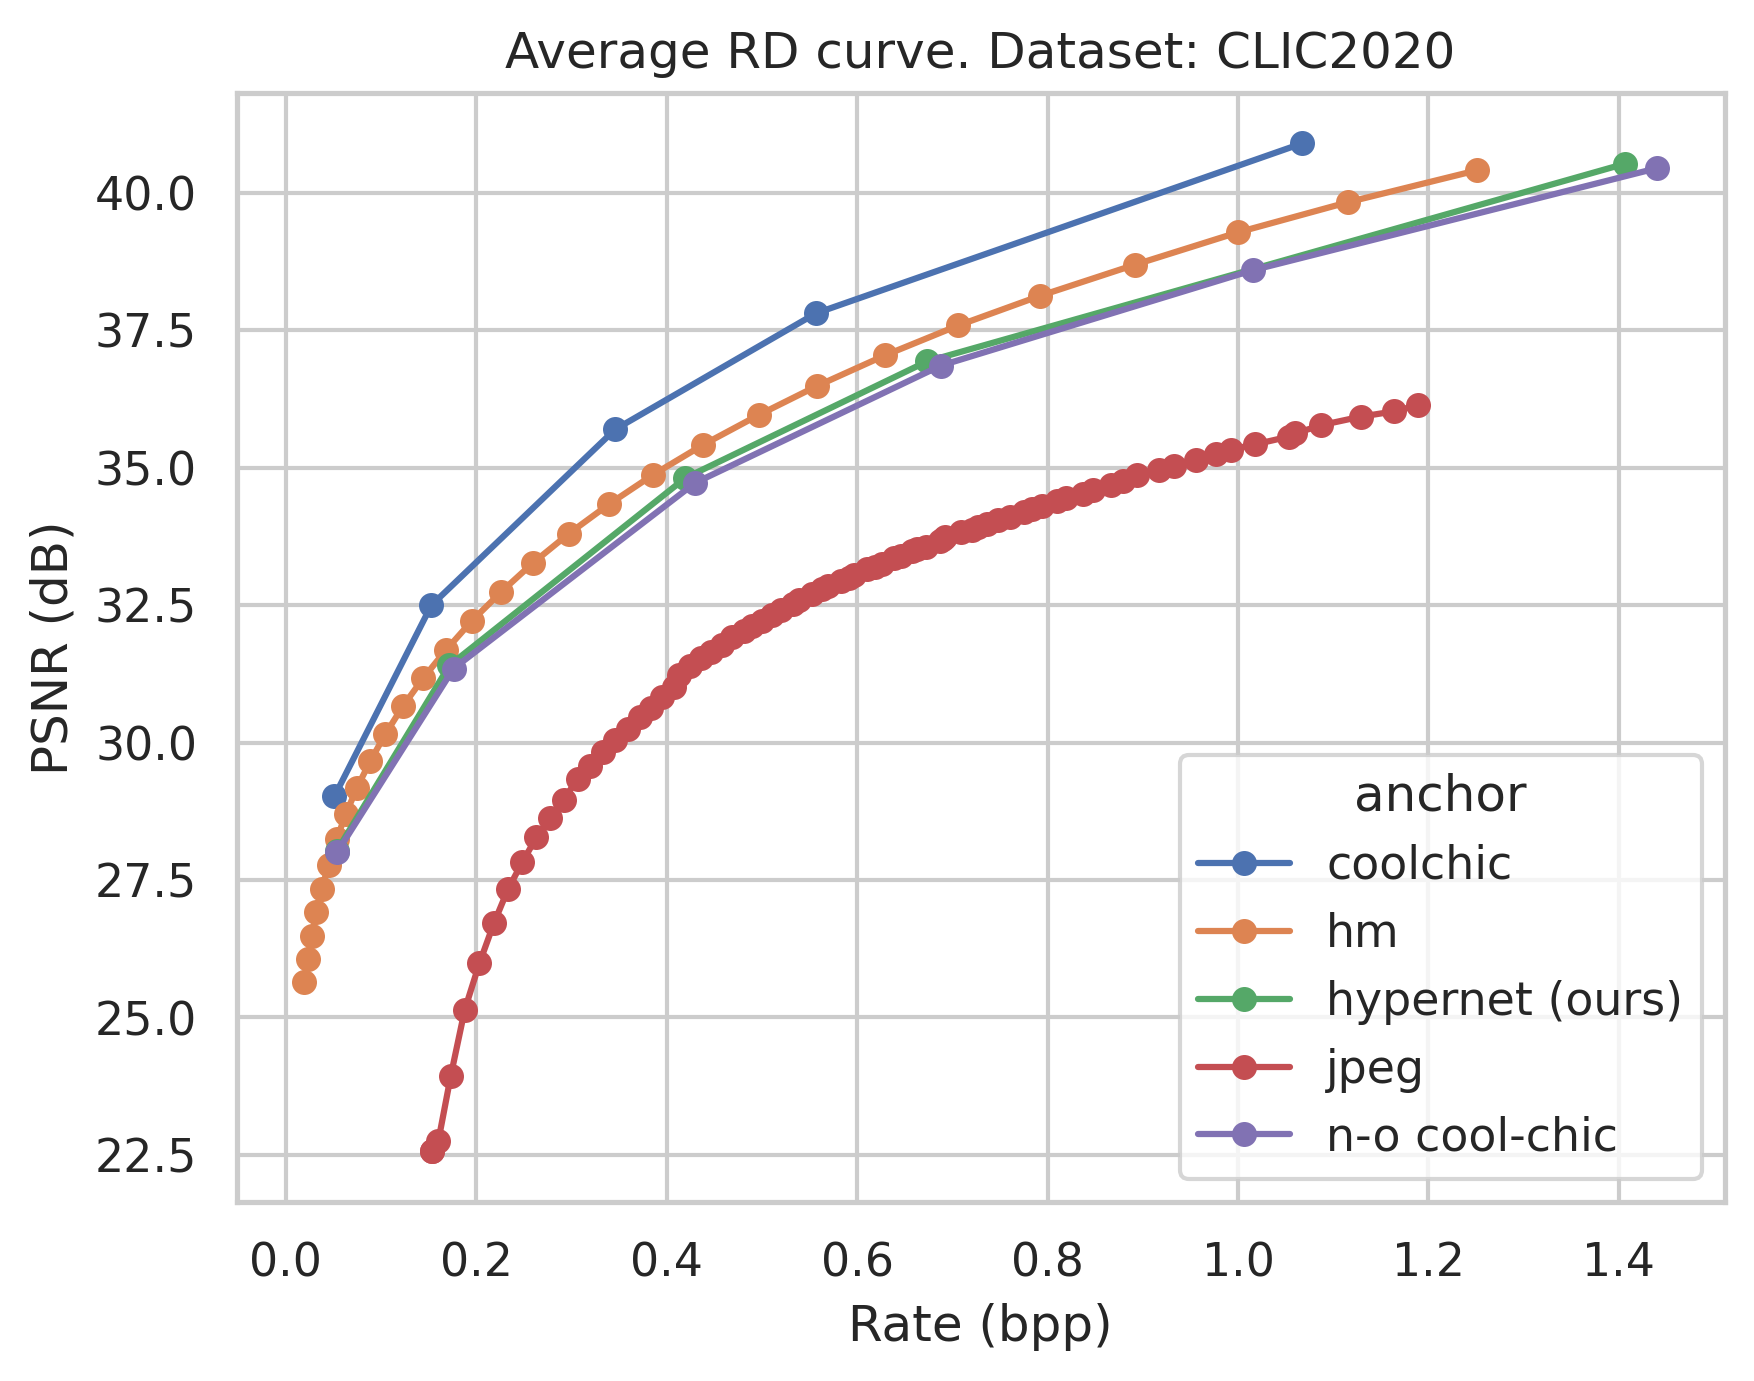

In [6]:
# df = rd_plots_from_dataset("kodak")  # get data and run existing plot code if needed
df = rd_plots_from_dataset_print("clic20-pro-valid")

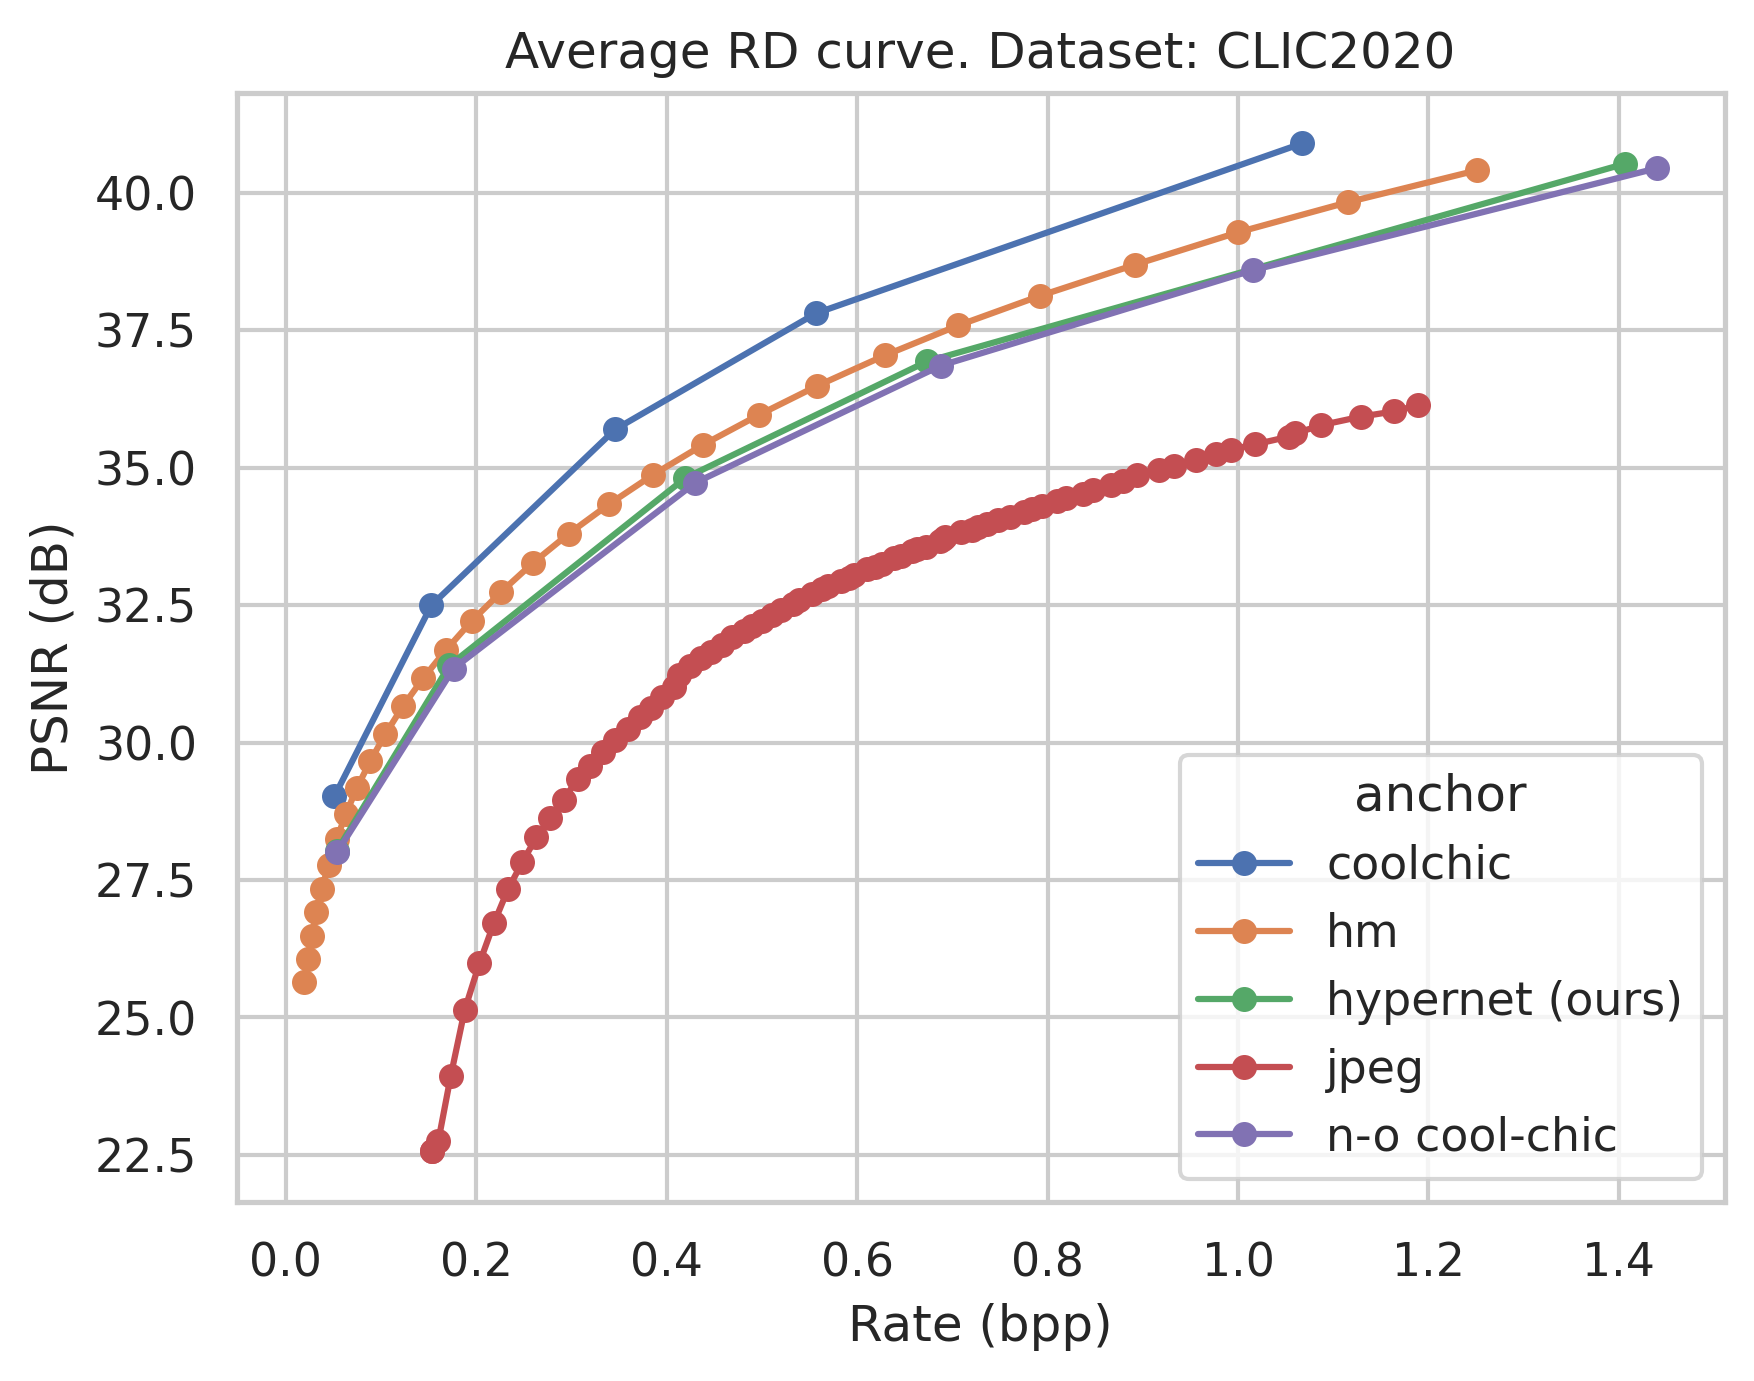

In [7]:
rd_plots_from_dataset("clic20-pro-valid")

# Plot 2: flops vs BD-rate

In [8]:
import matplotlib.pyplot as plt

# import pandas as pd
import seaborn as sns

# from coolchic.eval.hypernet import get_hypernet_flops
# from coolchic.hypernet.hypernet import DeltaWholeNet, NOWholeNet

sns.set_theme(context="notebook", style="whitegrid")

In [9]:
flops = {
    "coolchic": (
        coolchic_fwd := get_hypernet_flops(DeltaWholeNet, get_coolchic_flops=True)
    ),
    "coolchic_step": 3 * coolchic_fwd,
    "N-O Cool-chic": get_hypernet_flops(NOWholeNet),
    "Hypernet (ours)": get_hypernet_flops(DeltaWholeNet),
}

bd_rates = {
    "kodak": {
        "N-O Cool-chic": 37.33,
        "Hypernet (ours)": 33.60,
    },
    "clic20-pro-valid": {
        "N-O Cool-chic": 36.233904571367106,
        "Hypernet (ours)": 28.284958907776783,
    },
}

metrics_dfg = pd.DataFrame(
    [
        (dataset, method, bd_rate, flops[method])
        for dataset, bd_rates in bd_rates.items()
        for method, bd_rate in bd_rates.items()
    ],
    columns=["dataset", "method", "bd_rate", "flops"],
)
metrics_dfg["num_coolchic_steps"] = metrics_dfg["flops"] / flops["coolchic_step"]
metrics_dfg.head()

,dataset,method,bd_rate,flops,num_coolchic_steps
0,kodak,N-O Cool-chic,37.330000,38908956672,22.208348
1,kodak,Hypernet (ours),33.600000,48419561472,27.636784
2,clic20-pro-valid,N-O Cool-chic,36.233905,38908956672,22.208348
3,clic20-pro-valid,Hypernet (ours),28.284959,48419561472,27.636784


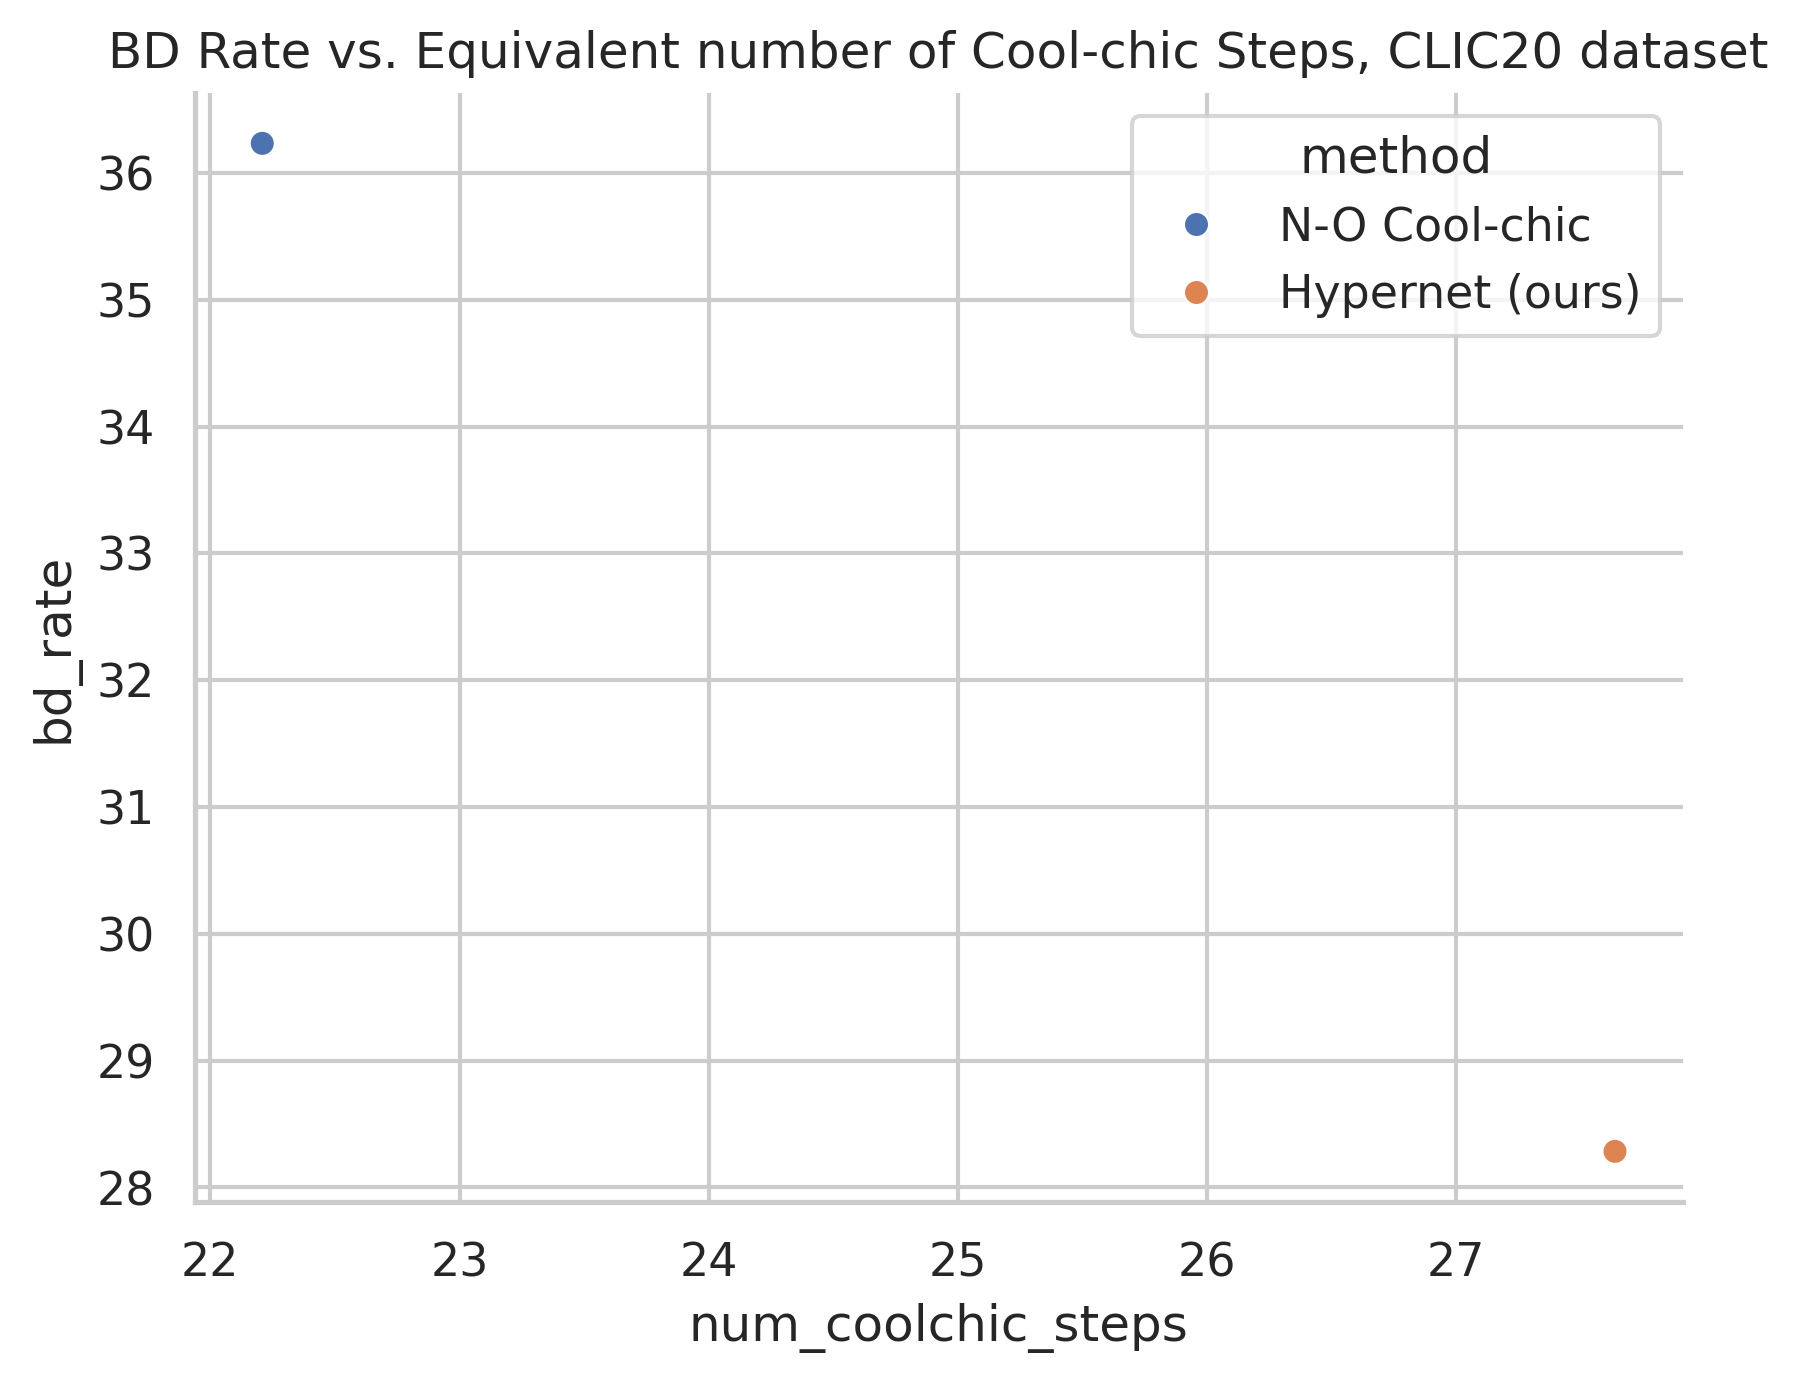

In [10]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=metrics_dfg[metrics_dfg["dataset"] == "clic20-pro-valid"],
    x="num_coolchic_steps",
    y="bd_rate",
    hue="method",
    ax=ax,
)
ax.set_title("BD Rate vs. Equivalent number of Cool-chic Steps, CLIC20 dataset")
sns.despine()

# Plot 4: show bd rate vs flops as training progresses

In [11]:
flops = {
    "coolchic": (
        coolchic_fwd := get_hypernet_flops(DeltaWholeNet, get_coolchic_flops=True)
    ),
    "coolchic_step": 3 * coolchic_fwd,
    "N-O Cool-chic": get_hypernet_flops(NOWholeNet),
    "Hypernet (ours)": get_hypernet_flops(DeltaWholeNet),
}

bd_rates = {
    "kodak": {
        "N-O Cool-chic": 37.33,
        "Hypernet (ours)": 33.60,
    },
    "clic20-pro-valid": {
        "N-O Cool-chic": 36.233904571367106,
        "Hypernet (ours)": 28.284958907776783,
    },
}


metrics_df = pd.DataFrame(
    [
        (dataset, method, bd_rate, flops[method])
        for dataset, bd_rates in bd_rates.items()
        for method, bd_rate in bd_rates.items()
    ],
    columns=["dataset", "method", "bd_rate", "flops"],
)
metrics_df["num_coolchic_steps"] = metrics_df["flops"] / flops["coolchic_step"]
metrics_df.head()

,dataset,method,bd_rate,flops,num_coolchic_steps
0,kodak,N-O Cool-chic,37.330000,38908956672,22.208348
1,kodak,Hypernet (ours),33.600000,48419561472,27.636784
2,clic20-pro-valid,N-O Cool-chic,36.233905,38908956672,22.208348
3,clic20-pro-valid,Hypernet (ours),28.284959,48419561472,27.636784


In [12]:
dataset = "clic20-pro-valid"
# dataset = "kodak"
method = "from-orange"
CONFIG_NUM_TO_LMBDA = {"00": 0.0001, "01": 0.0004, "02": 0.001, "03": 0.004, "04": 0.02}

finetuning_dir = RESULTS_DIR / "finetuning" / dataset
finetuning_df = pd.concat(
    [
        pd.read_csv(file).assign(anchor=f"{file.parent.stem}-finetuning")
        for file in finetuning_dir.glob("**/*.csv")
    ]
)
finetuning_df = finetuning_df.reset_index(drop=True)
finetuning_df["anchor"] = finetuning_df["anchor"].apply(
    lambda x: "N-O Cool-chic finetuning" if "nocc" in x else "Hypernet finetuning"
)

In [13]:
def get_bd_rate_from_df(df: pd.DataFrame) -> float:
    metrics = defaultdict(list)
    for _, row in df.iterrows():
        assert "seq_name" in row, "seq_name column is missing in the DataFrame"
        metrics[row["seq_name"]].append(
            SummaryEncodingMetrics(
                seq_name=row["seq_name"],
                lmbda=row["lmbda"],
                rate_bpp=row["rate_bpp"],
                psnr_db=row["psnr_db"],
            )
        )

    bds = bd_rates_summary_anchor_name(
        metrics, anchor="hm", dataset=dataset, only_latent_rate=False
    )
    assert len(bds) == 1, "Expected exactly one BD rate result."
    return list(bds.values())[0]


bd_df = (
    finetuning_df.groupby(["n_itr", "seq_name", "anchor"], group_keys=False)
    .apply(get_bd_rate_from_df)
    .reset_index()
    .rename(columns={0: "bd_rate"})
)
bd_df["num_coolchic_steps"] = (
    bd_df["n_itr"] + flops["N-O Cool-chic"] / flops["coolchic_step"]
)

/tmp/ipykernel_1380633/1849745674.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_bd_rate_from_df)


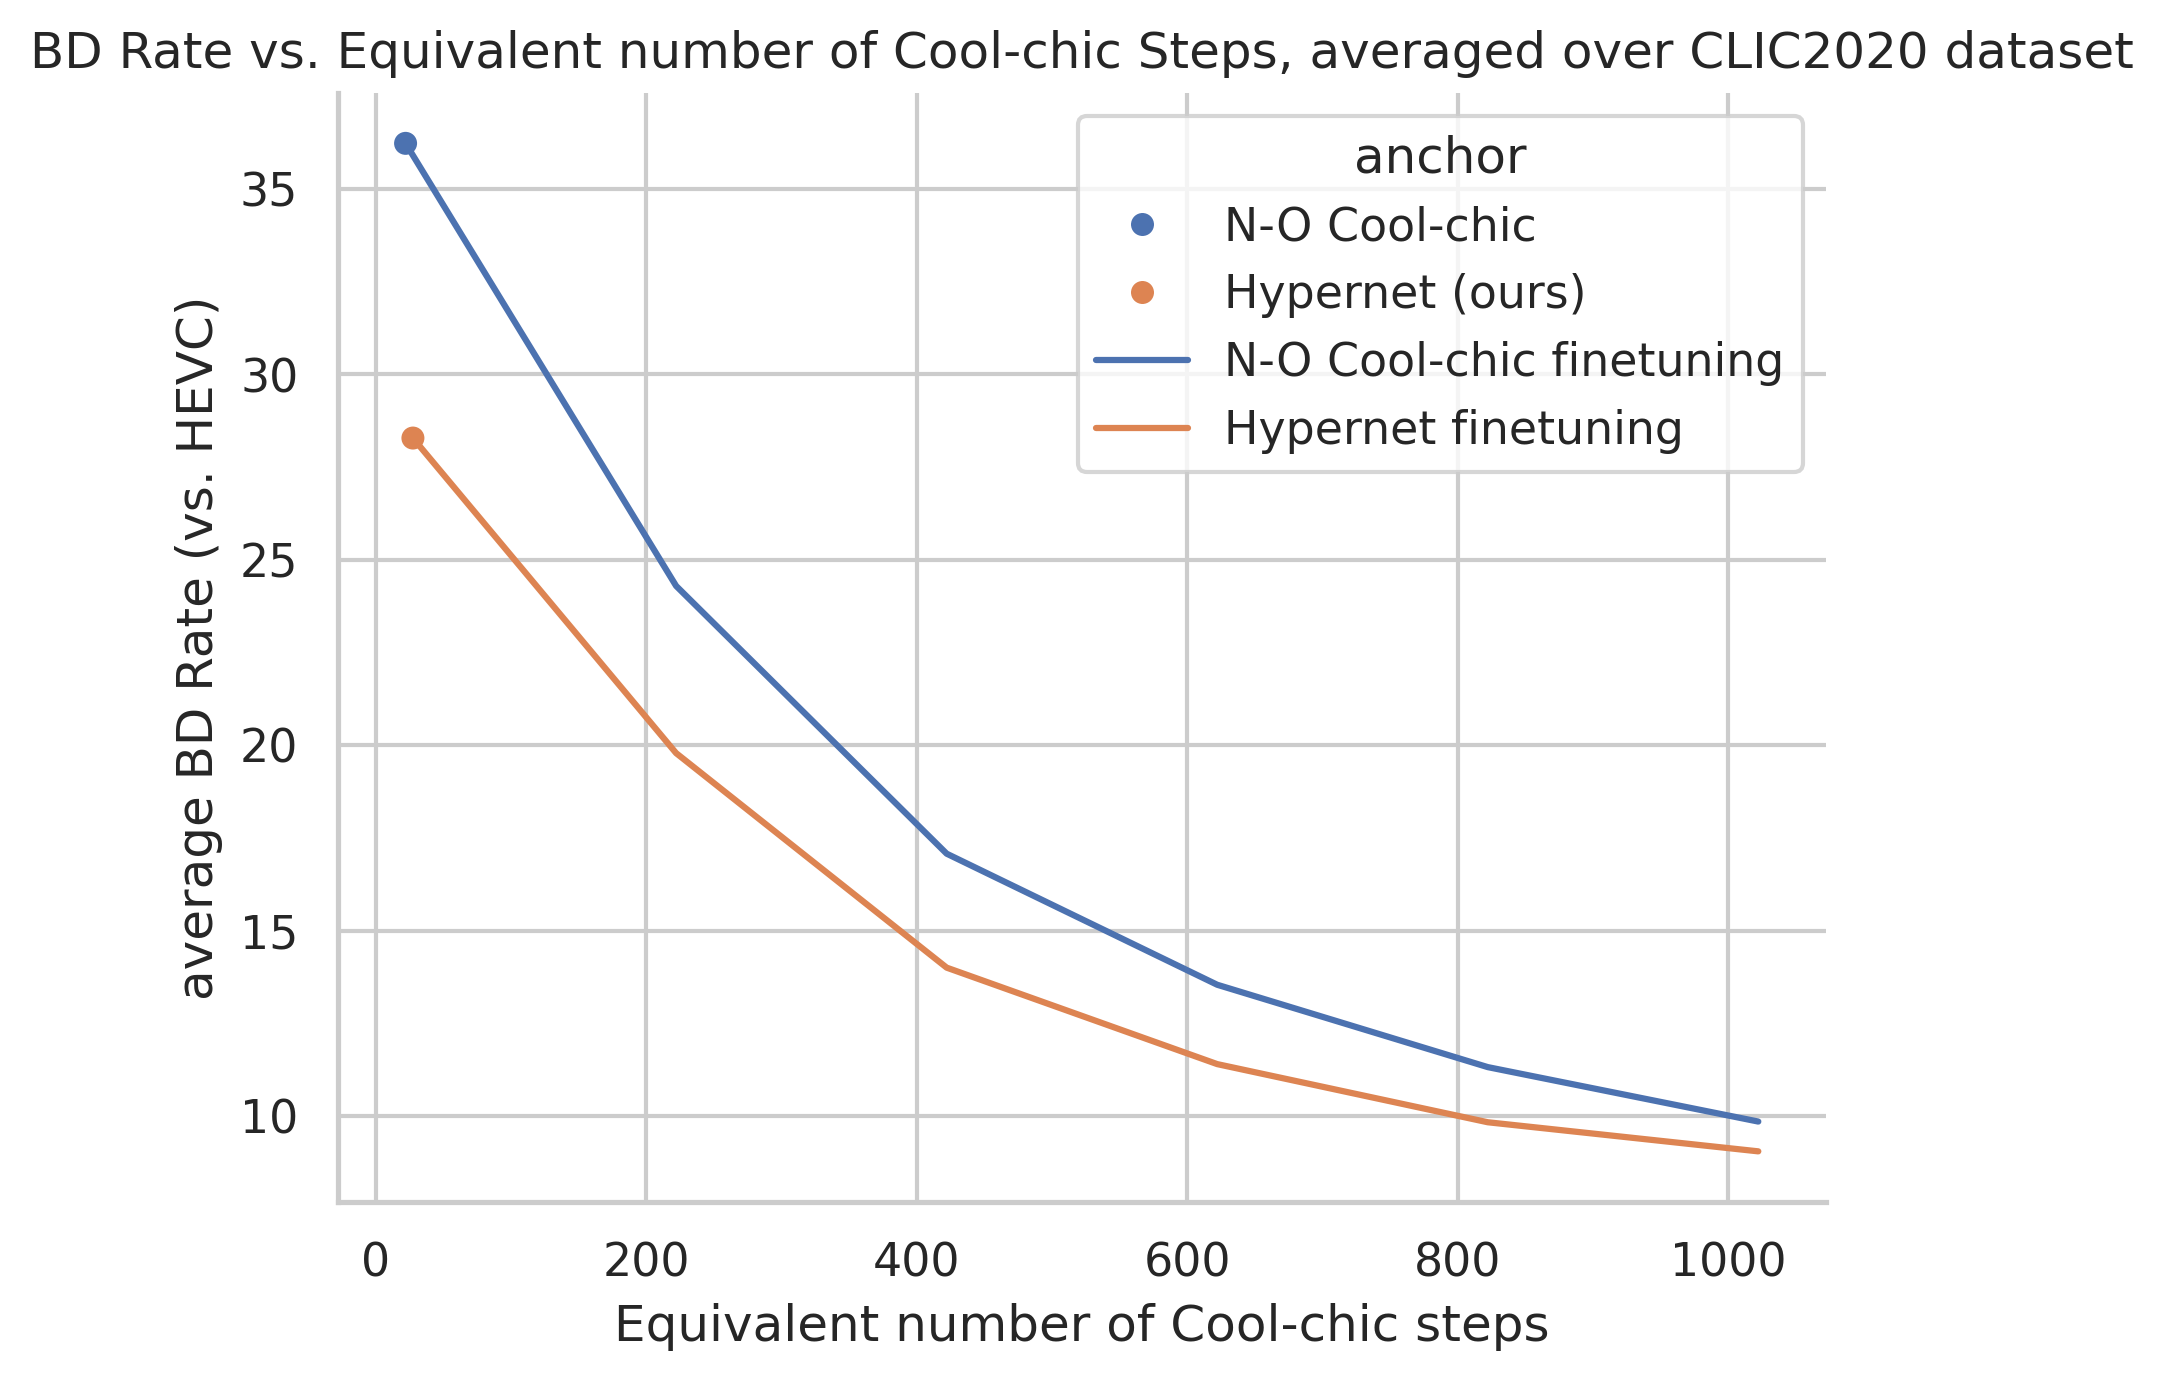

In [14]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=metrics_df[metrics_df["dataset"] == dataset],
    x="num_coolchic_steps",
    y="bd_rate",
    hue="method",
    ax=ax,
)
avg_bd_df = (
    bd_df.groupby(["anchor", "n_itr"])
    .agg({"bd_rate": "mean", "num_coolchic_steps": "mean"})
    .reset_index()
)
# Add the BD rates from the init points to give an impression of finetuning from the start.
avg_bd_df = pd.concat(
    [
        avg_bd_df,
        metrics_df[metrics_df["dataset"] == dataset][
            ["num_coolchic_steps", "bd_rate", "method"]
        ]
        .rename(columns={"method": "anchor"})
        .assign(
            anchor=lambda df: df["anchor"]
            .apply(lambda x: x.strip(" (ours)"))
            .apply(lambda x: f"{x} finetuning")
        )
        .assign(n_itr=0),
    ]
)
# Filter out the points in finetuning that are higher than the init points.
avg_bd_df = avg_bd_df[avg_bd_df.n_itr != 100]

# Need this to match the hue order with the scatter plot.
methods_used = [
    f"{name.strip(' (ours)')} finetuning" for name in metrics_df.method.unique()
]
sns.lineplot(
    data=avg_bd_df,
    x="num_coolchic_steps",
    y="bd_rate",
    hue="anchor",
    hue_order=methods_used,
    ax=ax,
)
ax.set_title(
    f"BD Rate vs. Equivalent number of Cool-chic Steps, averaged over {'CLIC2020' if dataset == 'clic20-pro-valid' else 'Kodak' if dataset == 'kodak' else None} dataset"
)
ax.set_xlabel("Equivalent number of Cool-chic steps")
ax.set_ylabel("average BD Rate (vs. HEVC)")
sns.despine()

=== Scatter Data ===
   num_coolchic_steps    bd_rate           method
2           22.208348  36.233905    N-O Cool-chic
3           27.636784  28.284959  Hypernet (ours)
=== Line Data ===
    num_coolchic_steps    bd_rate                    anchor  n_itr
1           222.208348  19.786088       Hypernet finetuning    200
2           422.208348  14.000361       Hypernet finetuning    400
3           622.208348  11.398329       Hypernet finetuning    600
4           822.208348   9.830041       Hypernet finetuning    800
5          1022.208348   9.045167       Hypernet finetuning   1000
7           222.208348  24.295819  N-O Cool-chic finetuning    200
8           422.208348  17.074338  N-O Cool-chic finetuning    400
9           622.208348  13.538789  N-O Cool-chic finetuning    600
10          822.208348  11.317410  N-O Cool-chic finetuning    800
11         1022.208348   9.848694  N-O Cool-chic finetuning   1000
2            22.208348  36.233905  N-O Cool-chic finetuning      0
3      

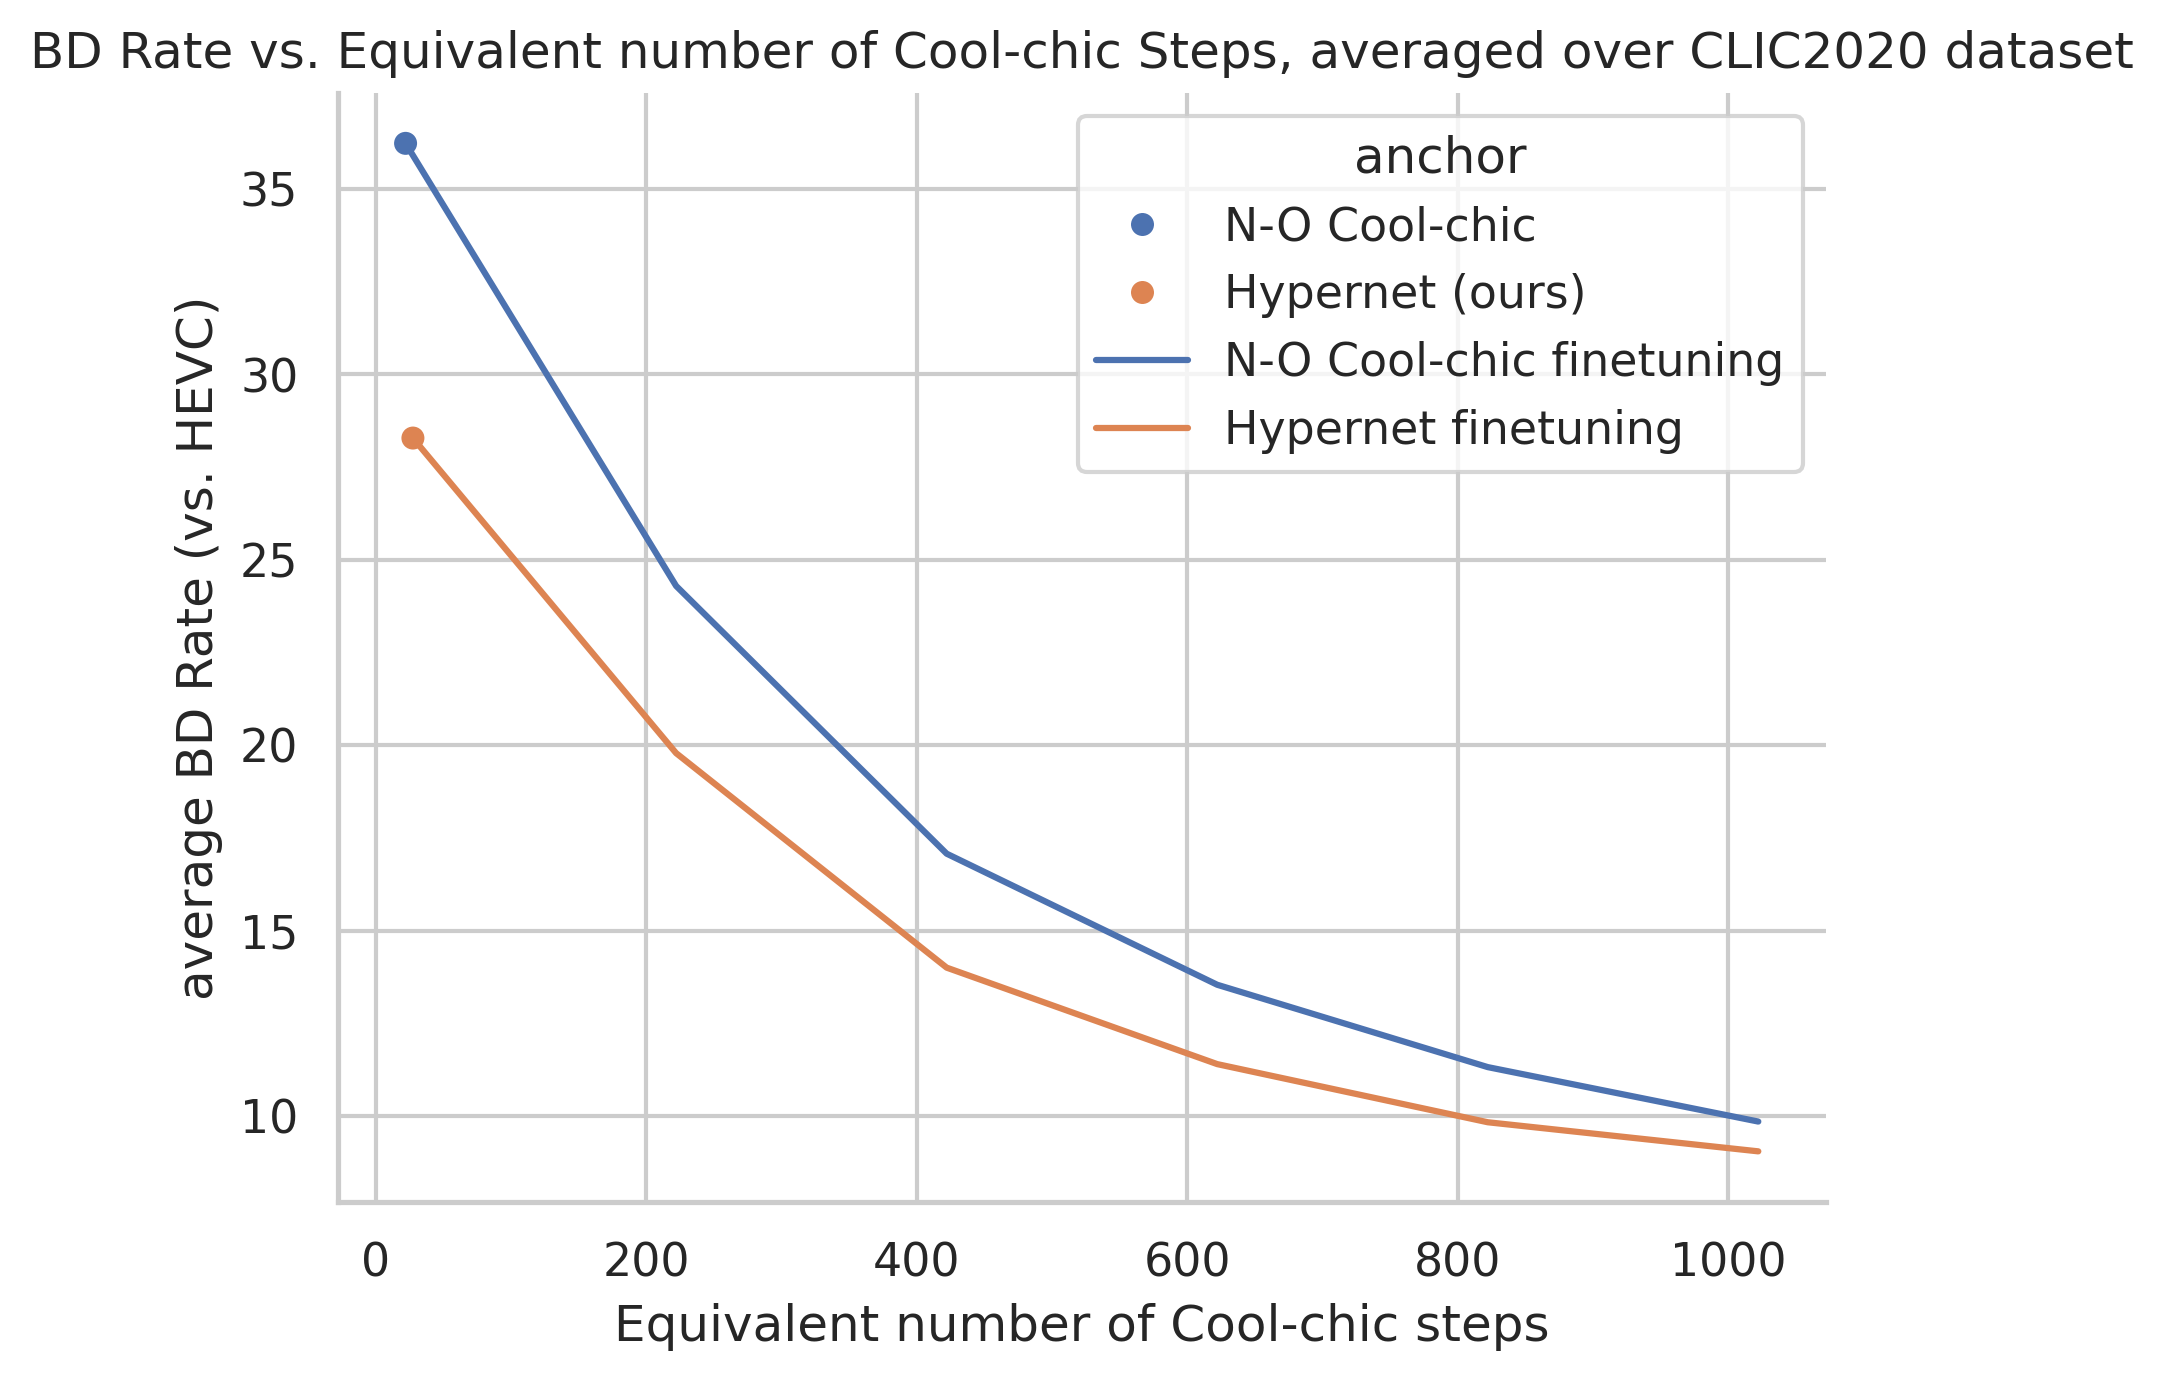

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()

# Scatter plot of raw data
scatter_data = metrics_df[metrics_df["dataset"] == dataset]
sns.scatterplot(
    data=scatter_data,
    x="num_coolchic_steps",
    y="bd_rate",
    hue="method",
    ax=ax,
)

# Print scatter plot data
print("=== Scatter Data ===")
print(scatter_data[["num_coolchic_steps", "bd_rate", "method"]])

# Create averaged lineplot data
avg_bd_df = (
    bd_df.groupby(["anchor", "n_itr"])
    .agg({"bd_rate": "mean", "num_coolchic_steps": "mean"})
    .reset_index()
)

# Add initial points (n_itr = 0) to the average data for visualizing finetuning starting points
init_points = (
    metrics_df[metrics_df["dataset"] == dataset][
        ["num_coolchic_steps", "bd_rate", "method"]
    ]
    .rename(columns={"method": "anchor"})
    .assign(
        anchor=lambda df: df["anchor"]
        .apply(lambda x: x.strip(" (ours)"))
        .apply(lambda x: f"{x} finetuning"),
        n_itr=0,
    )
)

# Concatenate init points to averaged data
avg_bd_df = pd.concat([avg_bd_df, init_points])

# Filter out final iteration points if needed
avg_bd_df = avg_bd_df[avg_bd_df.n_itr != 100]

# Define hue order to match scatter plot
methods_used = [
    f"{name.strip(' (ours)')} finetuning" for name in metrics_df.method.unique()
]

# Plot average BD rate over steps
sns.lineplot(
    data=avg_bd_df,
    x="num_coolchic_steps",
    y="bd_rate",
    hue="anchor",
    hue_order=methods_used,
    ax=ax,
)

# Print line plot data
print("=== Line Data ===")
print(avg_bd_df[["num_coolchic_steps", "bd_rate", "anchor", "n_itr"]])

# Titles and labels
ax.set_title(
    f"BD Rate vs. Equivalent number of Cool-chic Steps, averaged over {'CLIC2020' if dataset == 'clic20-pro-valid' else 'Kodak' if dataset == 'kodak' else None} dataset"
)
ax.set_xlabel("Equivalent number of Cool-chic steps")
ax.set_ylabel("average BD Rate (vs. HEVC)")

# Style
sns.despine()


In [16]:
# MACs per pixel of a Cool-chic training step.
flops["coolchic_step"] / (512**2)

6683.337890625

In [17]:
# MACs per pixel of a Cool-chic forward pass.
{name: flops[name] / (512**2) for name in flops}

{'coolchic': 2227.779296875,
 'coolchic_step': 6683.337890625,
 'N-O Cool-chic': 148425.890625,
 'Hypernet (ours)': 184705.96875}

# Plot 5: extra rate and benefits of adding each part

In [18]:
dataset = "kodak"
baseline_metrics = pd.DataFrame(
    [
        s.model_dump()
        for seq_res in parse_hypernet_metrics(
            RESULTS_DIR / "exps/no-cchic/orange-best/",
            dataset=dataset,
            premature=True,
        ).values()
        for s in seq_res
    ]
).assign(variant="baseline")
nosynth_metrics = pd.DataFrame(
    [
        s.model_dump()
        for seq_res in parse_hypernet_metrics(
            RESULTS_DIR / "eval_no_synth", dataset=dataset, premature=True
        ).values()
        for s in seq_res
    ]
).assign(variant="with ARM modulations")
noarm_metrics = pd.DataFrame(
    [
        s.model_dump()
        for seq_res in parse_hypernet_metrics(
            RESULTS_DIR / "eval_no_arm", dataset=dataset, premature=True
        ).values()
        for s in seq_res
    ]
).assign(variant="with synthesis modulations")
both_metrics = pd.DataFrame(
    [
        s.model_dump()
        for seq_res in parse_hypernet_metrics(
            RESULTS_DIR / "exps/delta-hn/ups-best-orange/",
            dataset=dataset,
            premature=True,
        ).values()
        for s in seq_res
    ]
).assign(variant="full hypernetwork (ours)")
all_metrics = pd.concat(
    [baseline_metrics, nosynth_metrics, noarm_metrics, both_metrics],
    ignore_index=True,
).sort_values(by=["seq_name", "lmbda"])

In [19]:
agg_df = all_metrics.groupby(["variant", "lmbda"]).agg(
    {
        "rate_nn_bpp": "mean",
        "psnr_db": "mean",
        "rate_latent_bpp": "mean",
    }
)

# First group the baseline rows by 'lmbda' and subtract them from each group.
baseline = agg_df.loc["baseline"]


def subtract_baseline(group):
    lmbda_val = group.name
    base_row = baseline.loc[lmbda_val]
    return group - base_row


# Apply the subtraction grouped by 'lmbda'
diffs = agg_df.groupby("lmbda").apply(subtract_baseline, include_groups=False)
diffs = (
    diffs.reset_index(level=0, drop=True)
    .drop("baseline", level=0)
    .reset_index()
    .sort_values(
        by=["variant", "lmbda"],
        key=lambda x: x.map(
            {
                "with ARM modulations": 0,
                "with synthesis modulations": 1,
                "full hypernetwork (ours)": 2,
            }
        ),
    )
    .rename(
        columns={
            "rate_nn_bpp": "rate_nn_bpp_diff",
            "psnr_db": "psnr_db_diff",
            "rate_latent_bpp": "rate_latent_bpp_diff",
        }
    )
)
diffs

,variant,lmbda,rate_nn_bpp_diff,psnr_db_diff,rate_latent_bpp_diff
1,with ARM modulations,0.0001,0.012973,-0.421376,0.087075
4,with ARM modulations,0.0002,0.012874,-2.407780,-0.369937
7,with ARM modulations,0.0004,0.010930,-3.067399,-0.352933
10,with ARM modulations,0.0010,0.008131,-4.067901,-0.365091
13,with ARM modulations,0.0040,0.003664,-3.733011,-0.173833
2,with synthesis modulations,0.0001,0.019579,0.076315,0.127187
5,with synthesis modulations,0.0002,0.013518,-2.165025,-0.338983
8,with synthesis modulations,0.0004,0.010756,-2.936028,-0.336062
11,with synthesis modulations,0.0010,0.007720,-3.973179,-0.355342
14,with synthesis modulations,0.0040,0.003631,-3.724599,-0.173383


In [20]:
# Melt the DataFrame for seaborn
plot_data = diffs.melt(
    id_vars=["variant"],
    value_vars=["rate_nn_bpp_diff", "rate_latent_bpp_diff", "psnr_db_diff"],
    var_name="metric",
    value_name="value",
)

# Separate data for the two axes
bpp_data = plot_data[plot_data["metric"].str.contains("bpp")]
psnr_data = plot_data[plot_data["metric"].str.contains("psnr")]

# Pivot the data and remove the baseline variant (its diff is always 0)
diffs_pivot = diffs.set_index("variant").loc[
    ["with ARM modulations", "with synthesis modulations", "full hypernetwork (ours)"]
]

In [21]:
def plot_ablation(diff_pivot_df: pd.DataFrame, lmbda_val: float | None = None) -> None:
    print("\n--- LaTeX Table ---")
    print(diff_pivot_df.to_latex(float_format="%.4f", column_format="lccc", bold_rows=True))


    # --- 4. Create the Plot ---
    fig, ax1 = plt.subplots(figsize=(6, 3))
    ax2 = ax1.twinx()

    # --- Bar properties ---
    variants = diff_pivot_df.index
    x_pos = np.arange(len(variants))  # The label locations [0, 1, 2]
    bar_width = 0.10  # Set the desired width of the bars
    offsets = np.array([-bar_width, 0, bar_width])  # Offsets for the three bars

    # Define colors
    # Dutch field and blue to yellow color palettes
    # https://www.heavy.ai/blog/12-color-palettes-for-telling-better-stories-with-your-data
    bpp1_color = "#115f9a"
    bpp2_color = "#22a7f0"
    psnr_color = "#e60049"  # A slightly different red

    # --- Plotting the bars manually ---
    # Plot BPP stems on ax1
    markerline, stemlines, baseline = ax1.stem(
        x_pos + offsets[0], diff_pivot_df["rate_nn_bpp_diff"]
    )
    plt.setp(markerline, marker="o", markersize=8, color=bpp1_color)
    plt.setp(stemlines, color=bpp1_color)
    plt.setp(baseline, visible=False)

    markerline, stemlines, baseline = ax1.stem(
        x_pos + offsets[1], diff_pivot_df["rate_latent_bpp_diff"]
    )
    plt.setp(markerline, marker="o", markersize=8, color=bpp2_color)
    plt.setp(stemlines, color=bpp2_color)
    plt.setp(baseline, visible=False)

    # Plot PSNR stems on ax2
    markerline, stemlines, baseline = ax2.stem(
        x_pos + offsets[2], diff_pivot_df["psnr_db_diff"]
    )
    plt.setp(markerline, marker="o", markersize=8, color=psnr_color)
    plt.setp(stemlines, color=psnr_color)
    plt.setp(baseline, visible=False)

    # --- 5. Customize the Plot ---
    ax1.set_title(
        f"Ablation Study: Metric changes with respect to N-O Cool-chic. Lambda: {lmbda_val if lmbda_val is not None else 'all'}",
        fontsize=12,
        pad=10,
    )
    ax1.set_xlabel("Model Variant", fontsize=10)
    ax1.set_ylabel(
        "$\\Delta$ bpp ($\\leftarrow$ better)", fontsize=10, color=bpp1_color
    )
    ax2.set_ylabel(
        "$\\Delta$ PSNR (dB) ($\\rightarrow$ better)", fontsize=10, color=psnr_color
    )
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(variants, fontsize=8)
    ax1.tick_params(axis="y", labelcolor=bpp1_color)
    ax2.tick_params(axis="y", labelcolor=psnr_color)
    ax2.spines["left"].set_color(bpp1_color)
    ax2.spines["right"].set_color(psnr_color)

    # --- 6. Align the zero-lines of the two axes (The Fix) ---
    # Get the current limits
    y1_min, y1_max = ax1.get_ylim()
    y2_min, y2_max = ax2.get_ylim()

    # Calculate the largest absolute value for each axis
    abs_max1 = max(abs(y1_min), abs(y1_max))
    abs_max2 = max(abs(y2_min), abs(y2_max))

    # Set symmetrical limits on both axes with a 10% margin
    ax1.set_ylim(-abs_max1 * 1.1, abs_max1 * 1.1)
    ax2.set_ylim(-abs_max2 * 1.1, abs_max2 * 1.1)

    # Now that they are aligned, one zero-line is sufficient
    ax1.axhline(0, color="black", linewidth=1.0, linestyle="--", zorder=0)

    # --- 6. Create a Manual Legend ---
    legend_elements = [
        Patch(
            facecolor=bpp1_color,
            edgecolor="black",
            label="$\\Delta$ Modulation rate (bpp, low is better)",
        ),
        Patch(
            facecolor=bpp2_color,
            edgecolor="black",
            label="$\\Delta$ Latent rate (bpp, low is better)",
        ),
        Patch(
            facecolor=psnr_color,
            edgecolor="black",
            label="$\\Delta$ PSNR (dB, high is better)",
        ),
    ]
    ax1.legend(
        handles=legend_elements,
        loc="lower center",
        # bbox_to_anchor=(0.5, 0.15),
        # ncol=3,
        fancybox=True,
        shadow=False,
        fontsize=7,
    )

    # Adjust axis limits to prevent bars from touching the edges
    ax1_min, ax1_max = ax1.get_ylim()
    ax1.set_ylim(ax1_min * 1.15, ax1_max * 1.15)
    ax2_min, ax2_max = ax2.get_ylim()
    ax2.set_ylim(ax2_min * 1.15, ax2_max * 1.15)

    # plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    plt.tight_layout()  # Adjust layout to make room for the title
    plt.show()


--- LaTeX Table ---
\begin{tabular}{lccc}
\toprule
 & lmbda & rate_nn_bpp_diff & psnr_db_diff & rate_latent_bpp_diff \\
variant &  &  &  &  \\
\midrule
\textbf{with ARM modulations} & 0.0001 & 0.0130 & -0.4214 & 0.0871 \\
\textbf{with synthesis modulations} & 0.0001 & 0.0196 & 0.0763 & 0.1272 \\
\textbf{full hypernetwork (ours)} & 0.0001 & 0.0139 & 0.0201 & -0.0365 \\
\bottomrule
\end{tabular}



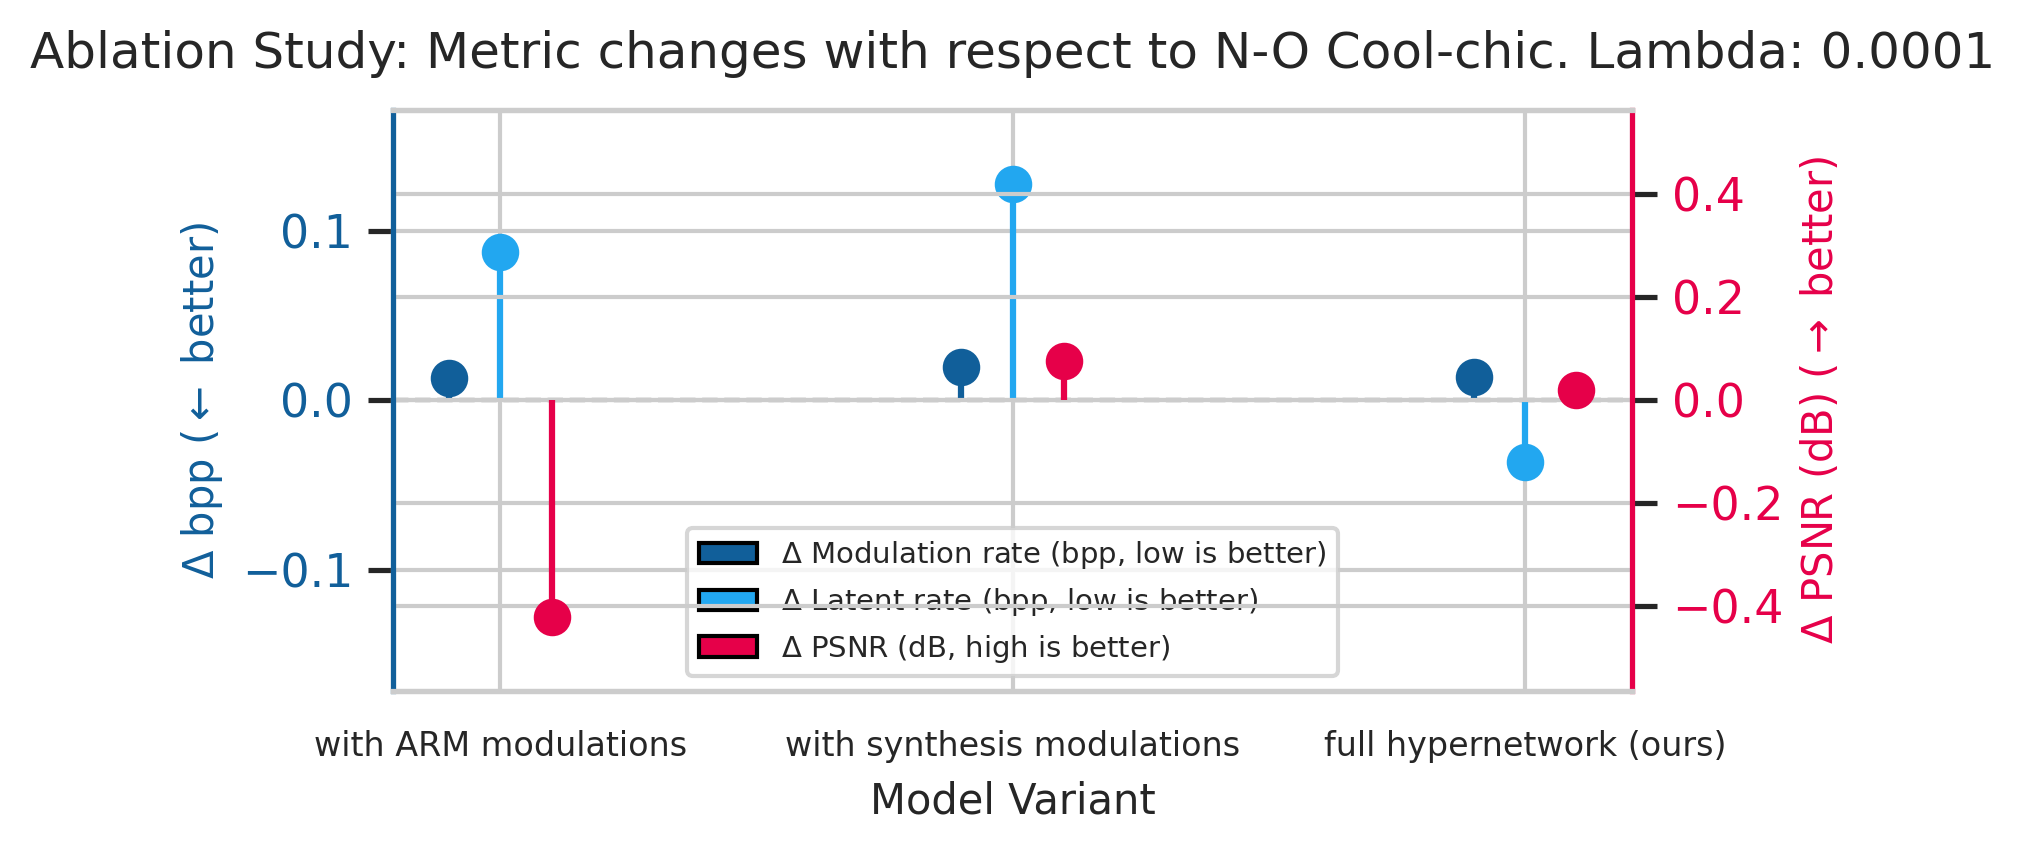


--- LaTeX Table ---
\begin{tabular}{lccc}
\toprule
 & lmbda & rate_nn_bpp_diff & psnr_db_diff & rate_latent_bpp_diff \\
variant &  &  &  &  \\
\midrule
\textbf{with ARM modulations} & 0.0002 & 0.0129 & -2.4078 & -0.3699 \\
\textbf{with synthesis modulations} & 0.0002 & 0.0135 & -2.1650 & -0.3390 \\
\textbf{full hypernetwork (ours)} & 0.0002 & 0.0098 & -2.0977 & -0.4198 \\
\bottomrule
\end{tabular}



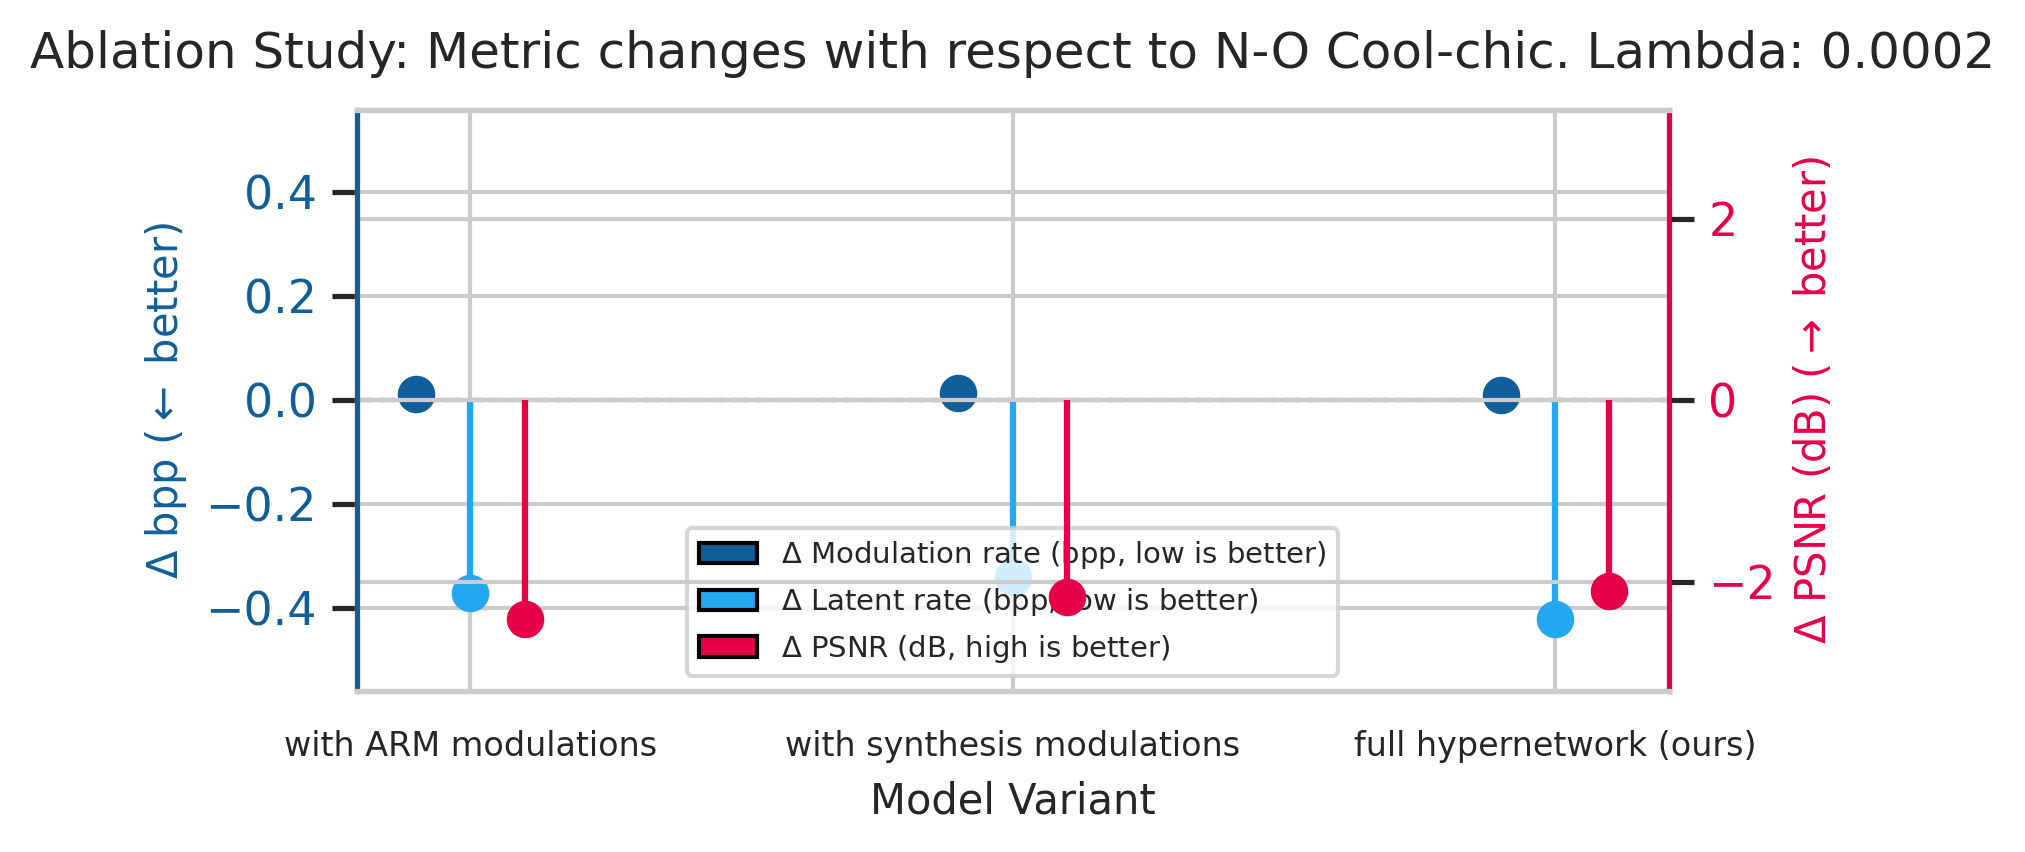


--- LaTeX Table ---
\begin{tabular}{lccc}
\toprule
 & lmbda & rate_nn_bpp_diff & psnr_db_diff & rate_latent_bpp_diff \\
variant &  &  &  &  \\
\midrule
\textbf{with ARM modulations} & 0.0004 & 0.0109 & -3.0674 & -0.3529 \\
\textbf{with synthesis modulations} & 0.0004 & 0.0108 & -2.9360 & -0.3361 \\
\textbf{full hypernetwork (ours)} & 0.0004 & 0.0080 & -2.7559 & -0.3634 \\
\bottomrule
\end{tabular}



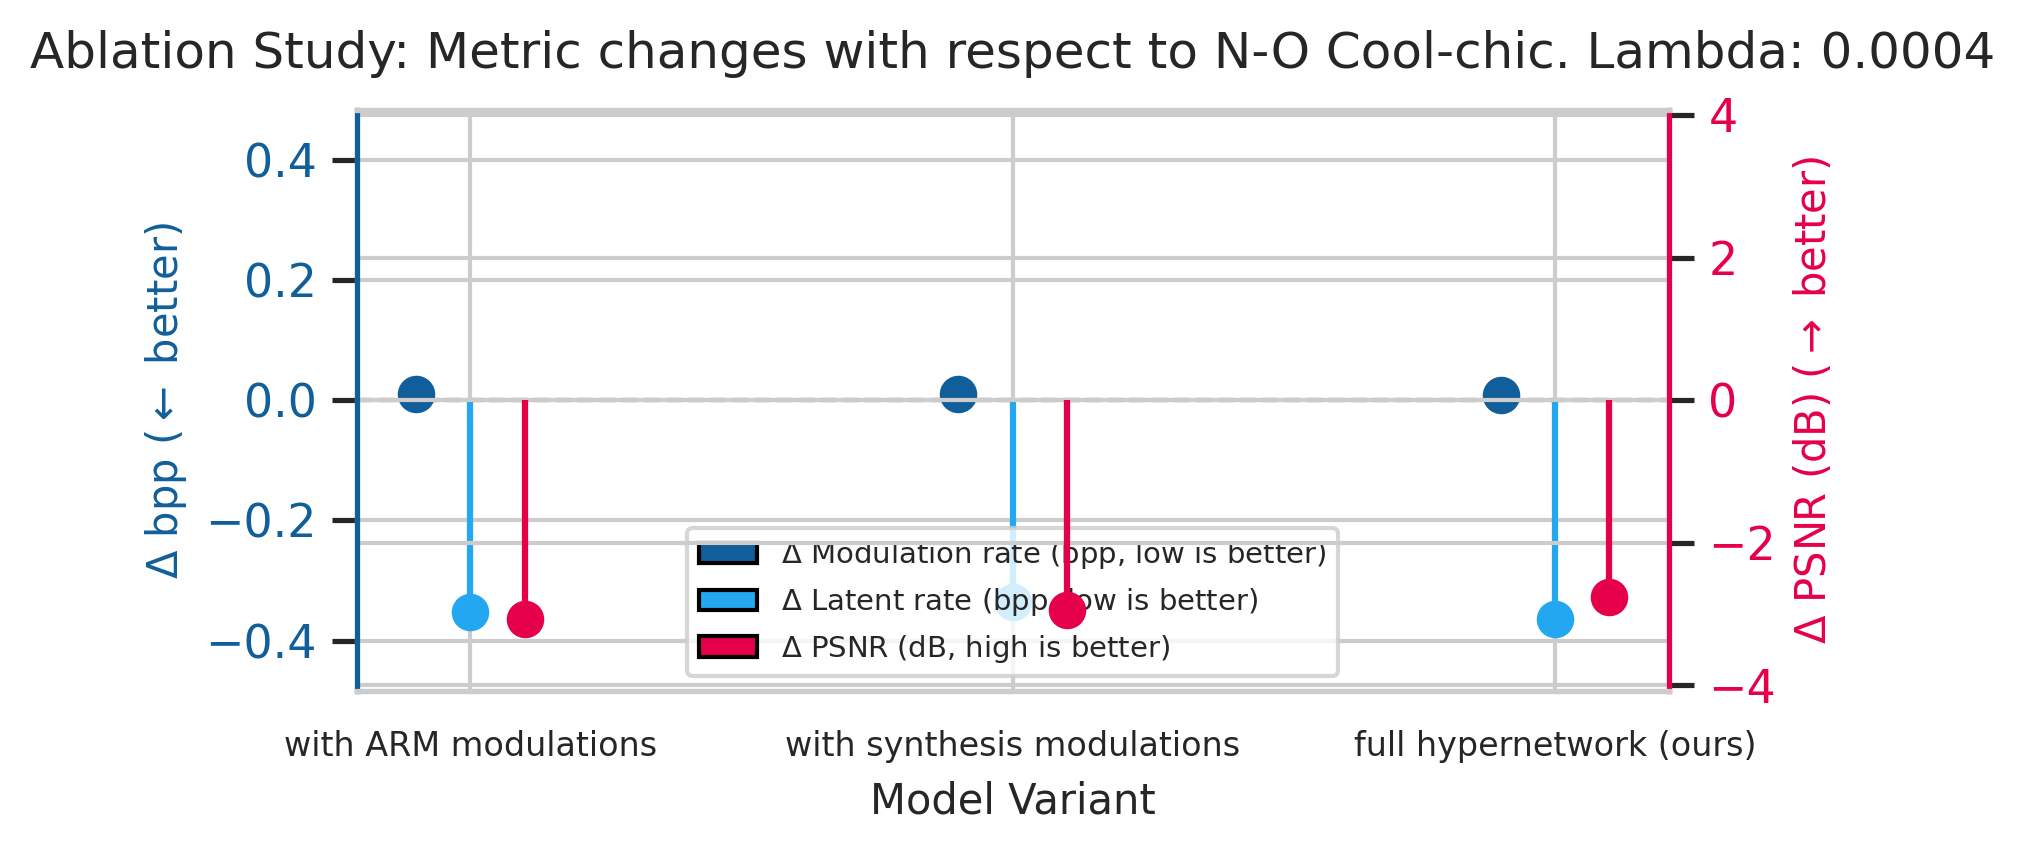


--- LaTeX Table ---
\begin{tabular}{lccc}
\toprule
 & lmbda & rate_nn_bpp_diff & psnr_db_diff & rate_latent_bpp_diff \\
variant &  &  &  &  \\
\midrule
\textbf{with ARM modulations} & 0.0010 & 0.0081 & -4.0679 & -0.3651 \\
\textbf{with synthesis modulations} & 0.0010 & 0.0077 & -3.9732 & -0.3553 \\
\textbf{full hypernetwork (ours)} & 0.0010 & 0.0031 & -3.8248 & -0.3667 \\
\bottomrule
\end{tabular}



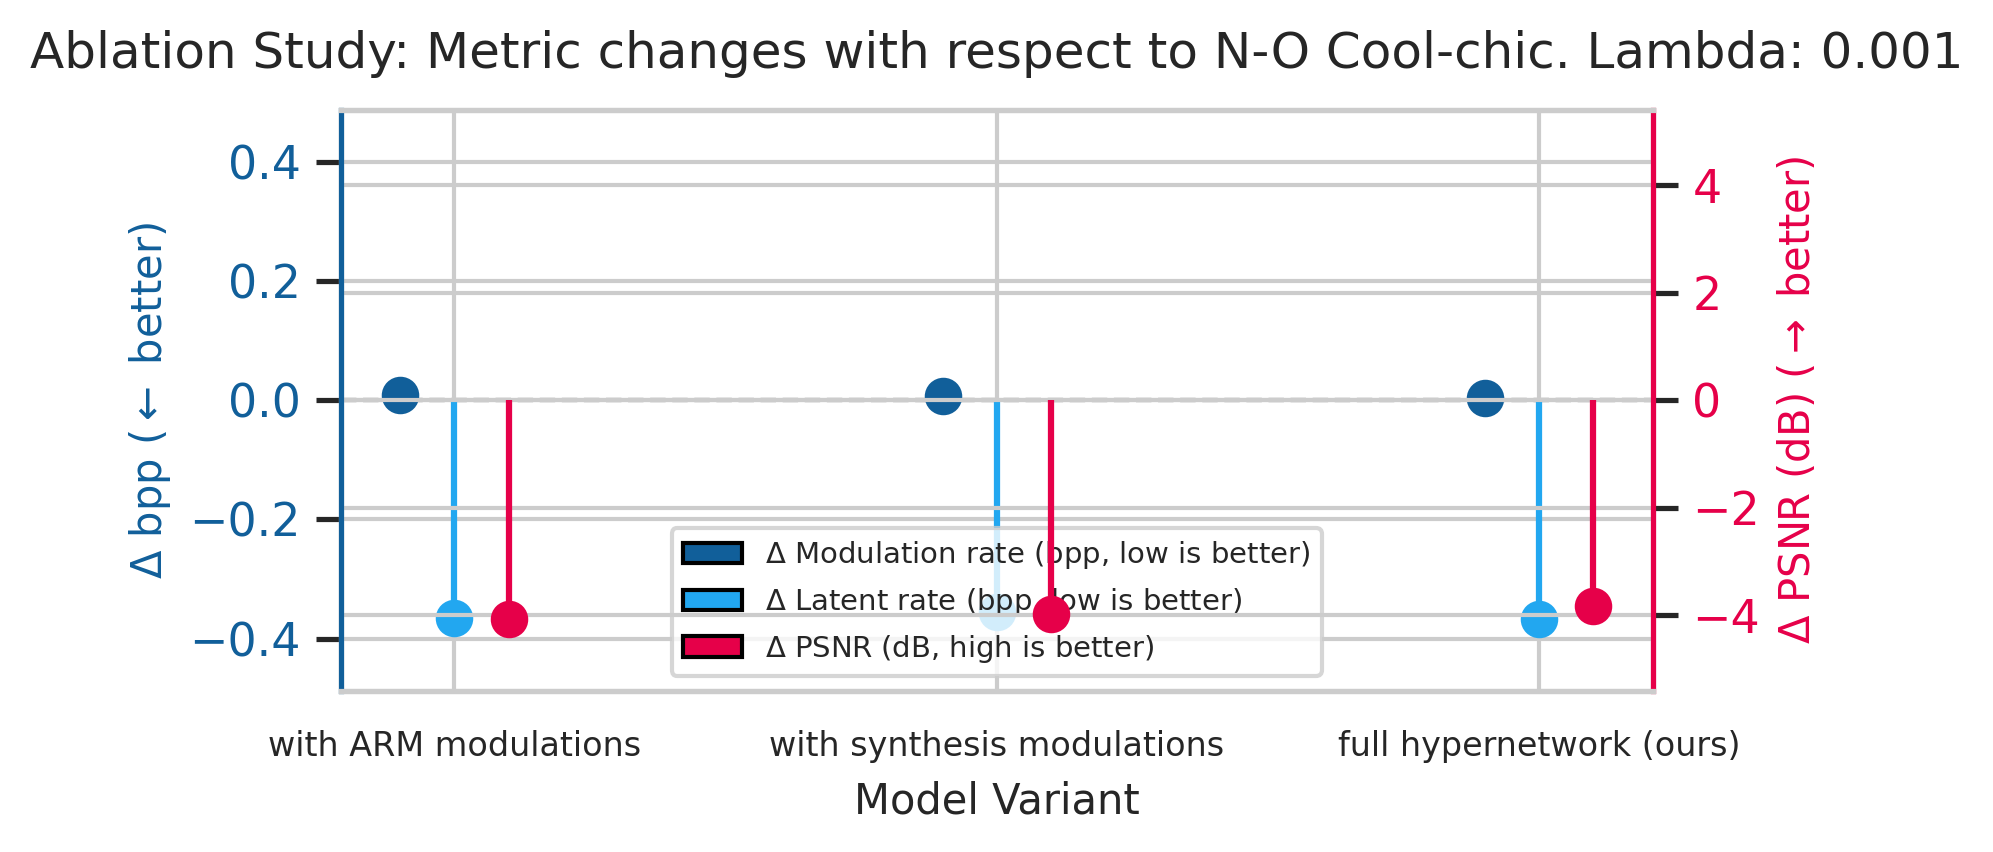


--- LaTeX Table ---
\begin{tabular}{lccc}
\toprule
 & lmbda & rate_nn_bpp_diff & psnr_db_diff & rate_latent_bpp_diff \\
variant &  &  &  &  \\
\midrule
\textbf{with ARM modulations} & 0.0040 & 0.0037 & -3.7330 & -0.1738 \\
\textbf{with synthesis modulations} & 0.0040 & 0.0036 & -3.7246 & -0.1734 \\
\textbf{full hypernetwork (ours)} & 0.0040 & 0.0000 & -3.6154 & -0.1781 \\
\bottomrule
\end{tabular}



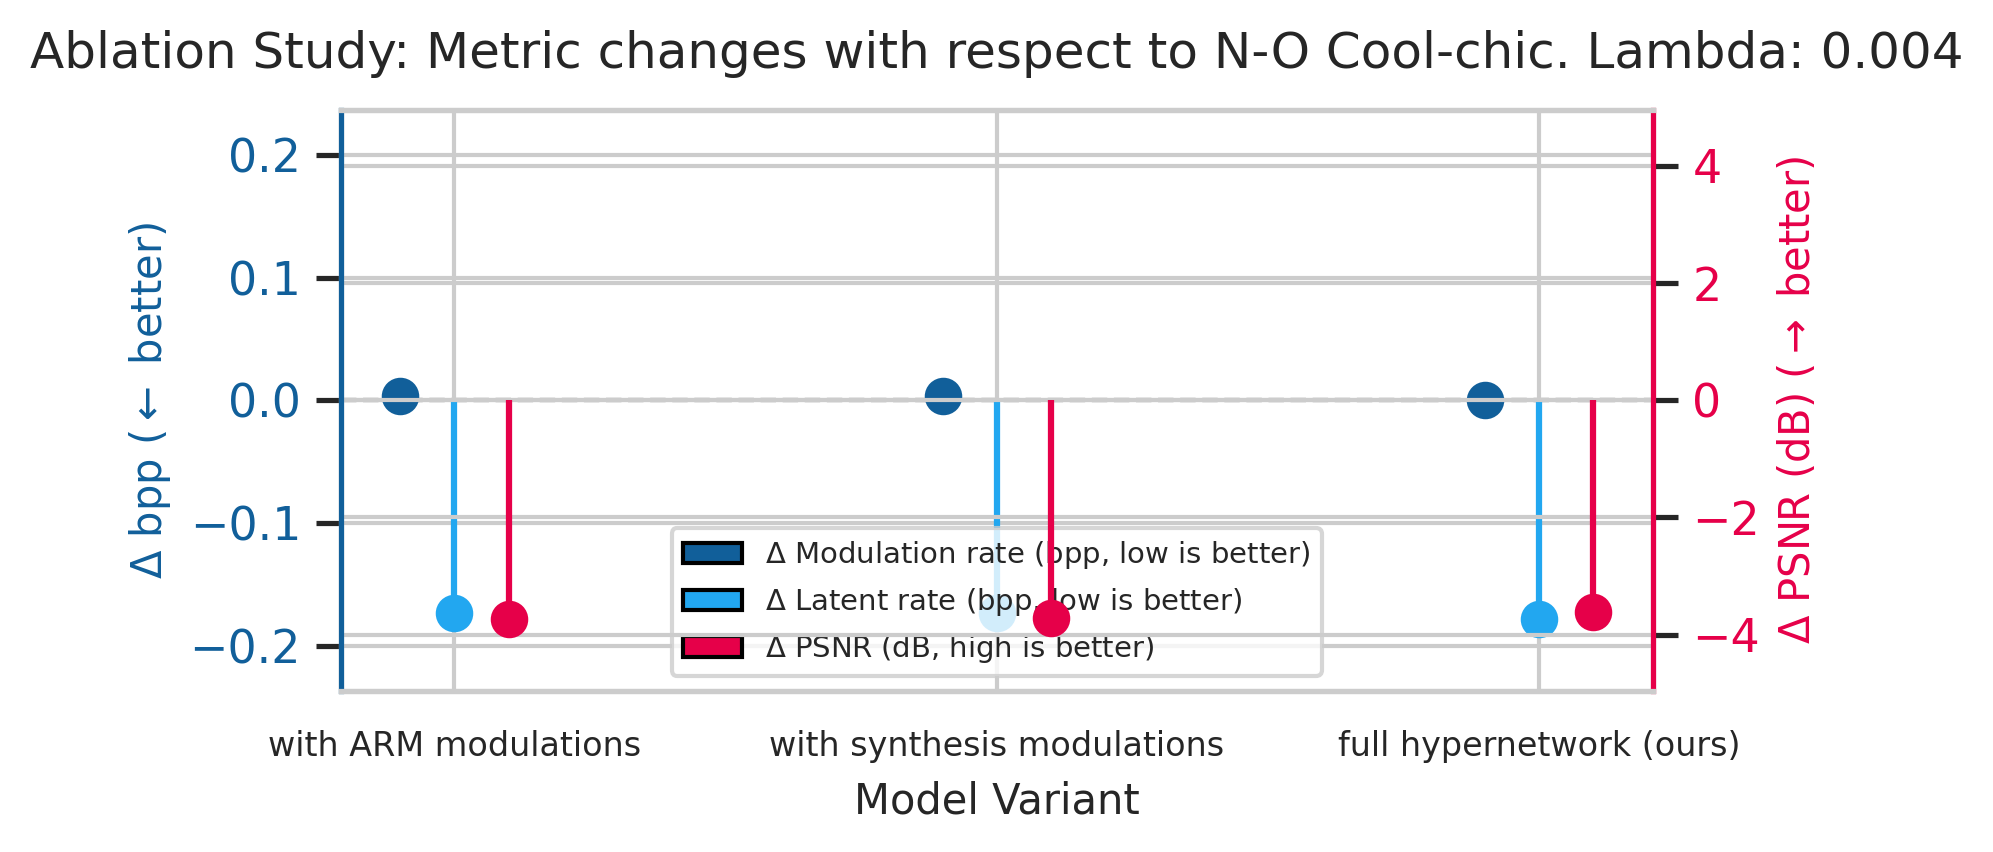

In [22]:
for lmbd in diffs_pivot.lmbda.unique():
    plot_ablation(diffs_pivot[diffs_pivot.lmbda == lmbd], lmbda_val=lmbd)

In [23]:
# same but in a table
for lmbd in diffs_pivot.lmbda.unique():
    print(f"Lambda: {lmbd}")
    print(
        diffs_pivot.loc[diffs_pivot.lmbda == lmbd][
            ["rate_nn_bpp_diff", "rate_latent_bpp_diff", "psnr_db_diff"]
        ].reset_index()
    )
    print("\n")

Lambda: 0.0001
                      variant  rate_nn_bpp_diff  rate_latent_bpp_diff  \
0        with ARM modulations          0.012973              0.087075   
1  with synthesis modulations          0.019579              0.127187   
2    full hypernetwork (ours)          0.013893             -0.036495   

   psnr_db_diff  
0     -0.421376  
1      0.076315  
2      0.020123  


Lambda: 0.0002
                      variant  rate_nn_bpp_diff  rate_latent_bpp_diff  \
0        with ARM modulations          0.012874             -0.369937   
1  with synthesis modulations          0.013518             -0.338983   
2    full hypernetwork (ours)          0.009776             -0.419797   

   psnr_db_diff  
0     -2.407780  
1     -2.165025  
2     -2.097731  


Lambda: 0.0004
                      variant  rate_nn_bpp_diff  rate_latent_bpp_diff  \
0        with ARM modulations          0.010930             -0.352933   
1  with synthesis modulations          0.010756             -0.336062   
2 